   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.1 MB/s eta 0:00:00
✅ Libraries installed and ready.
✅ Data Loaded. Shape: (45211, 17)

Starting TVAE Training (this takes ~10-15 mins)...


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(


✅ Training Complete!
Synthetic data saved.

--- 1. Class Distributions ---
Real Data:
 y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64
Synthetic Data:
 y
no     0.899847
yes    0.100153
Name: proportion, dtype: float64

--- 2. Generating Visualizations (Heatmaps & KDE) ---


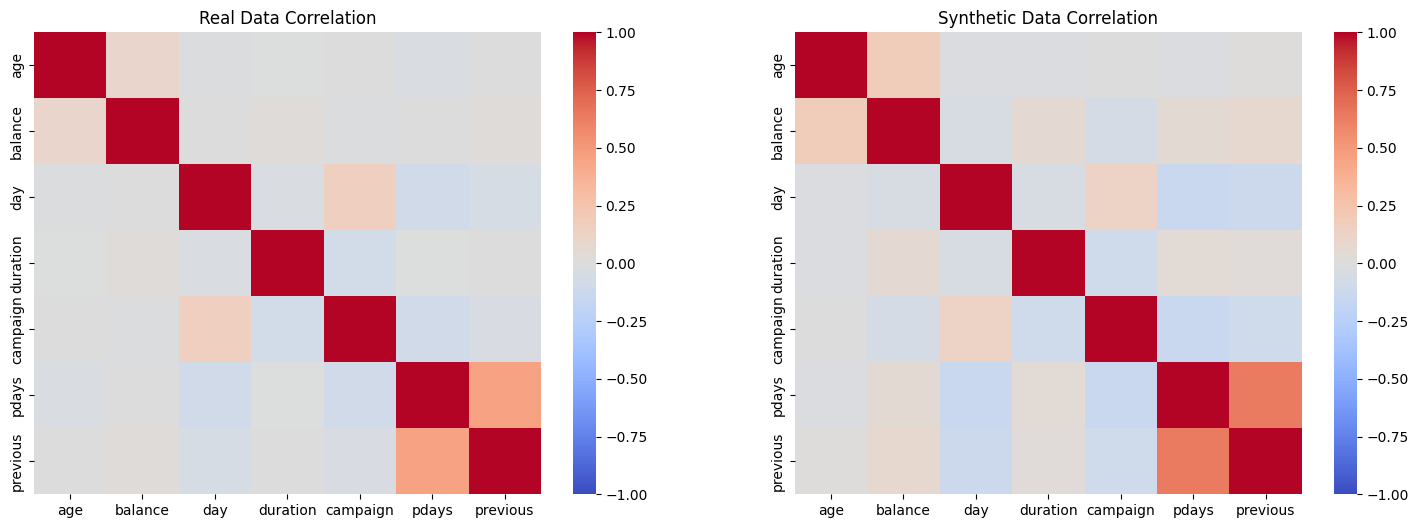

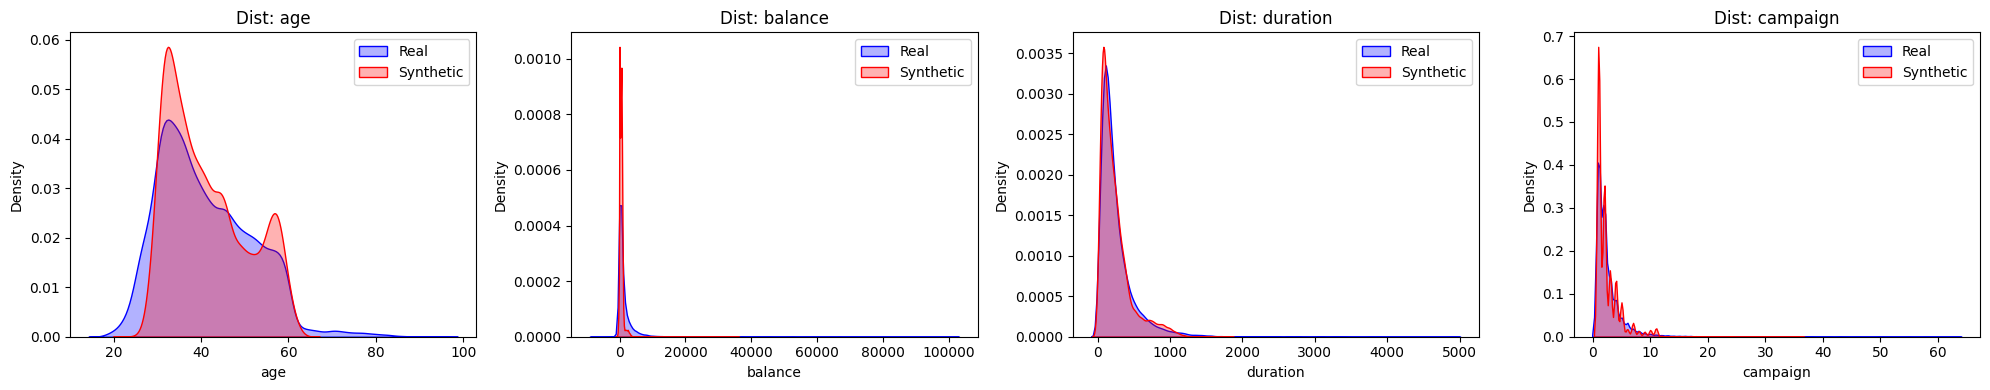


Scaling data for Neural Network...
Training NN on Real Data...
Training NN on Synthetic Data...

      NEURAL NETWORK UTILITY RESULTS      
Real Data      -> Accuracy: 0.9011, F1 Score: 0.4957
Synthetic Data -> Accuracy: 0.7554, F1 Score: 0.3853

F1 Score Gap: 0.1103


In [ ]:
# --- Phase 0: Install & Import ---
!pip install sdv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import io
import requests
import os
import urllib3

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

# SDV Imports
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer
from sdv.evaluation.single_table import evaluate_quality

# Suppress SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

print("✅ Libraries installed and ready.")

# --- Phase 1: Data Loading (Fixed SSL Error) ---
url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
print(f"Downloading data from {url}...")

# FIX: verify=False bypasses the expired certificate error
r = requests.get(url, verify=False)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content/temp_folder")

with zipfile.ZipFile("/content/temp_folder/bank.zip", 'r') as z_inner:
    z_inner.extractall("/content/bank_data")

real_data = pd.read_csv("/content/bank_data/bank-full.csv", sep=';')
print(f"✅ Data Loaded. Shape: {real_data.shape}")

# --- Phase 2: Model Implementation (TVAE) ---
# 1. Define Metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)

# 2. Configure TVAE
synthesizer = TVAESynthesizer(
    metadata,
    epochs=500,
    batch_size=500
)

print("\nStarting TVAE Training (this takes ~10-15 mins)...")
synthesizer.fit(real_data)
print("✅ Training Complete!")

# 3. Generate Synthetic Data
synthetic_data = synthesizer.sample(num_rows=len(real_data))

# 4. Save to CSV
synthetic_data.to_csv('synthetic_bank_data_nn.csv', index=False)
print("Synthetic data saved.")

# --- Phase 3: Statistical & Visual Validation ---
print("\n--- 1. Class Distributions ---")
print("Real Data:\n", real_data['y'].value_counts(normalize=True))
print("Synthetic Data:\n", synthetic_data['y'].value_counts(normalize=True))

print("\n--- 2. Generating Visualizations (Heatmaps & KDE) ---")

def plot_visualizations(real, synthetic):
    # Part A: Correlation Heatmap
    # Filter only numeric columns for correlation
    real_corr = real.select_dtypes(include=np.number).corr()
    syn_corr = synthetic.select_dtypes(include=np.number).corr()

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    sns.heatmap(real_corr, ax=axes[0], annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    axes[0].set_title("Real Data Correlation")

    sns.heatmap(syn_corr, ax=axes[1], annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1].set_title("Synthetic Data Correlation")
    plt.show()

    # Part B: KDE (Distribution) Plots
    # We plot key columns to check if the shapes match
    columns_to_plot = ['age', 'balance', 'duration', 'campaign']

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    for i, col in enumerate(columns_to_plot):
        if col in real.columns:
            sns.kdeplot(real[col], ax=axes[i], label='Real', fill=True, alpha=0.3, color='blue')
            sns.kdeplot(synthetic[col], ax=axes[i], label='Synthetic', fill=True, alpha=0.3, color='red')
            axes[i].set_title(f'Dist: {col}')
            axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_visualizations(real_data, synthetic_data)

# --- Phase 4: Utility Test (Neural Network / MLP) ---

# Helper: Encode categorical columns
def prepare_for_nn(df):
    df_ml = df.copy()
    le = LabelEncoder()
    for col in df_ml.select_dtypes(include='object').columns:
        df_ml[col] = le.fit_transform(df_ml[col])
    return df_ml

# 1. Prepare Data
real_ml = prepare_for_nn(real_data)
syn_ml = prepare_for_nn(synthetic_data)

X_real = real_ml.drop('y', axis=1)
y_real = real_ml['y']
X_syn = syn_ml.drop('y', axis=1)
y_syn = syn_ml['y']

# 2. SCALING (Critical for Neural Networks)
print("\nScaling data for Neural Network...")
scaler = StandardScaler()

# Fit scaler on Real data, apply to both
X_real_scaled = scaler.fit_transform(X_real)
X_syn_scaled = scaler.transform(X_syn)

# 3. Split Real Data (Test set MUST be real)
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real_scaled, y_real, test_size=0.3, random_state=42
)

# 4. Define the Neural Network Model
def get_neural_net():
    return MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        early_stopping=True
    )

# 5. Train on Real (Baseline)
print("Training NN on Real Data...")
nn_real = get_neural_net()
nn_real.fit(X_train_real, y_train_real)
pred_real = nn_real.predict(X_test_real)

# 6. Train on Synthetic (Experiment)
print("Training NN on Synthetic Data...")
nn_syn = get_neural_net()
nn_syn.fit(X_syn_scaled, y_syn)
pred_syn = nn_syn.predict(X_test_real)

# 7. Final Comparison
acc_real = accuracy_score(y_test_real, pred_real)
f1_real = f1_score(y_test_real, pred_real)

acc_syn = accuracy_score(y_test_real, pred_syn)
f1_syn = f1_score(y_test_real, pred_syn)

print("\n" + "="*40)
print("      NEURAL NETWORK UTILITY RESULTS      ")
print("="*40)
print(f"Real Data      -> Accuracy: {acc_real:.4f}, F1 Score: {f1_real:.4f}")
print(f"Synthetic Data -> Accuracy: {acc_syn:.4f}, F1 Score: {f1_syn:.4f}")

print(f"\nF1 Score Gap: {abs(f1_real - f1_syn):.4f}")

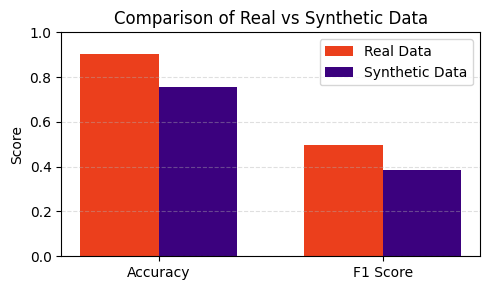

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Given values
acc_real = 0.9011
acc_syn  = 0.7554
f1_real  = 0.4957
f1_syn   = 0.3853

# Groups (Accuracy, F1 Score)
metrics = ['Accuracy', 'F1 Score']

# Real and Synthetic values in order
real_values = [acc_real, f1_real]
syn_values  = [acc_syn, f1_syn]

x = np.arange(len(metrics))      # positions for groups (2 groups)
width = 0.35                     # width of each bar

plt.figure(figsize=(5,3))

# Bars
plt.bar(x - width/2, real_values, width, label='Real Data', color='#eb3f1c')
plt.bar(x + width/2, syn_values,  width, label='Synthetic Data', color='#3b017e')

# Labels
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Comparison of Real vs Synthetic Data')

plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()
